In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt

functions for the genetic algorithm

In [3]:
# generating a set of feasible solutions / cronosomes
# every gene is a level where there is a call, the elements are the order in wich they are answered
def generateChronosome(size, number_of_elevators):
    chronosome = []
    for i in range(0,size):
        gene = random.randint(1,number_of_elevators)
        chronosome.append(gene)
    return chronosome

def generateChronosomes(size, population_size, number_of_elevators):
    chronosomes = []
    for i in range(0, population_size):
        chronosome = generateChronosome(size, number_of_elevators)
        chronosomes.append(chronosome)
    return chronosomes

# fitness
def countFitness(FN, CN, DF, CB, CA, DB, BFT, LT, OT, CT):
    N1 = abs(FN - CN) # N1 - number of floor between passanger and elevator
    N2 = abs(FN - DF) # N2 - number of floors between passanger and elevator
    WT = BFT + N1 + LT * CB + LT * DB + OT # waiting time of a passanger
    DT = CT + LT * CA + BFT * N2 + LT * DB + OT # destination time of a passanger
    JT = DT + WT # journey time, the obj of the EDP
    return JT

# count fitness for every chronosome
def countFitnessForChronosomes(elevator_floors, calls, chronosomes, BFT, LT, OT, CT):
    fitness_values = []
    n = len(chronosomes[0])
    FN = elevator_floors[:]
    number_of_elevators = len(elevator_floors)
    for chronosome in chronosomes:
        fitness = 0
        CB = [0] * number_of_elevators # CB - number of calls made before current passanger
        DB = [0] * number_of_elevators # DB - number of drops offs before current passanger
        for i in range(0, n):
            CN = calls[i][0] # CN - call floor number
            DF = calls[i][1] # DF - destination floor number
            CA = n - i - 1 # CA - number of calls made after the current passanger
            fitness += countFitness(FN[chronosome[i]-1], CN, DF, CB[chronosome[i]-1], CA, DB[chronosome[i]-1], BFT, LT, OT, CT)
            CB[chronosome[i]-1] += 1
            for j in range(i, len(calls)):
                if FN[chronosome[i]-1] < calls[j][1] < DF:
                    DB[chronosome[i]-1] += 1
            FN[chronosome[i]-1] = calls[i][1]
        fitness_values.append(fitness / n)
    return fitness_values

# helper

def getWinner(fitness_values, chronosomes):
    sorted_indexes = np.argsort(fitness_values).tolist()
    elite_member = chronosomes[sorted_indexes[0]]
    best_fitness = fitness_values[sorted_indexes[0]]
    return elite_member, best_fitness

crossover variants

In [4]:
def random_crossover(parent1, parent2):
    child1 = parent2[:]
    child2 = parent1[:]
    number_of_genes = len(parent1)
    number_of_genes_to_swap = random.randint(1, number_of_genes - 1)
    positions_to_swap = random.sample(range(number_of_genes), number_of_genes_to_swap)
    for i in positions_to_swap:
        child1[i] = parent1[i]
        child2[i] = parent2[i]
    return child1, child2


mutation variants

In [5]:
def swapMutation(number_of_genes, mutant_member):
    a = random.randint(0, number_of_genes - 1)
    b = random.randint(0, number_of_genes - 1)
    gene = mutant_member[a]
    mutant_member[a] = mutant_member[b]
    mutant_member[b] = gene
    return mutant_member

def inversion_mutation(mutant_member):
    number_of_genes = len(mutant_member)
    a = random.randint(1,number_of_genes - 1)
    b = random.randint(1,number_of_genes - 1)
    start = min(a, b)
    stop = max(a, b)
    start = 2
    stop = 5
    cc = mutant_member[:]
    pos = stop
    for i in range(start, stop+1):
        mutant_member[i] = cc[pos]
        pos -= 1
    return mutant_member

def insertion_mutation(mutant_member):
    number_of_genes = len(mutant_member)
    positions = random.sample(range(number_of_genes), 2)
    pos1 = positions[0]
    pos2 = positions[1]
    first_half = mutant_member[:pos2]
    second_half = mutant_member[pos2:]
    if (first_half.count(mutant_member[pos1])):
        first_half.remove(mutant_member[pos1])
    elif (second_half.count(mutant_member[pos1])):
        second_half.remove(mutant_member[pos1])
    first_half.append(mutant_member[pos1])
    mutant_member = first_half + second_half
    return mutant_member

def exchange_mutation(mutant_member):
    number_of_genes = len(mutant_member)
    positions = random.sample(range(number_of_genes), 2)
    a = mutant_member[positions[0]]
    mutant_member[positions[0]] = mutant_member[positions[1]]
    mutant_member[positions[1]] = a
    return mutant_member

functions for the measurements

In [6]:
# wait time for a passenger to the elevator
def countPassangerWaitTimeForElevator(FN, CN, CB, DB, BFT, LT, OT):
    N1 = abs(FN - CN) # N1 - number of floor between passanger and elevator
    WT = BFT + N1 + LT * CB + LT * DB + OT # waiting time of a passanger
    return WT

# wait times for passangers, calculated from the solution
def calculateWaitTimesForElevatorFromChronosome(number_of_elevators, elevator_floors, calls_from_article, solution, BFT, LT, OT):
    FN = elevator_floors[:]
    calls = calls_from_article
    wait_times = []
    DB = [0] * number_of_elevators
    CB = [0] * number_of_elevators
    for i in range(0, len(solution)):
        CN = calls[i][0]
        DF = calls[i][1]
        WT = countPassangerWaitTimeForElevator(FN[solution[i]-1], CN, CB[solution[i]-1], DB[solution[i]-1], BFT, LT, OT)
        CB[solution[i]-1] += 1
        for j in range(i, len(calls)):
            if FN[solution[i]-1] < calls[j][1] < DF:
                DB[solution[i]-1] += 1
        FN[solution[i]-1] = calls[i][1]
        wait_times.append(WT)
    return wait_times

genetic algoritm

In [7]:
def geneticAlgorithm(
        number_of_elevators, elevator_floors, 
        m, BFT, LT, OT, CT, number_of_genes, calls, i_max, 
        crossover_rate, mutation_rate, crossover_type, mutation_type):
    
    chronosomes = generateChronosomes(number_of_genes, m, number_of_elevators)

    fitness_values = countFitnessForChronosomes(elevator_floors, calls, chronosomes, BFT, LT, OT, CT)
    
    all_fitness_winners = []
    
    for i in range (0, i_max):
        
        # categorisation by fitness values : elite, cross-over, mutant
        sorted_indexes = np.argsort(fitness_values).tolist()
        elite_member = chronosomes[sorted_indexes[0]]
        crossover_member_1 = chronosomes[sorted_indexes[1]]
        crossover_member_2 = chronosomes[sorted_indexes[2]]
        mutant_member = chronosomes[sorted_indexes[3]]

        sv = fitness_values[sorted_indexes[0]]

        # cross-over operations
        crossover = False
        if random.uniform(0, 1) > crossover_rate:
            crossover = True
            match crossover_type:
                case 1:
                    child1, child2 = random_crossover(crossover_member_1, crossover_member_2)
                
        # mutation operations -- swap mutation -- select two pos at random and swap them
        mutation = False
        if random.uniform(0, 1) > mutation_rate:
            mutation = True
            match mutation_type:
                case 1:
                    mutated = swapMutation(number_of_genes, mutant_member)
                case 2: 
                    mutated = inversion_mutation(mutant_member)
                case 3:
                    mutated = insertion_mutation(mutant_member)
                case 4:
                    mutated = exchange_mutation(mutant_member)

        # compute fitness values again after the operations
        new_chronosomes = []
        new_chronosomes.append(elite_member)
        if crossover:
            new_chronosomes.append(child1)
            new_chronosomes.append(child2)
        else:
            new_chronosomes.append(generateChronosome(number_of_genes, number_of_elevators))
            new_chronosomes.append(generateChronosome(number_of_genes, number_of_elevators))
        if mutation:
            new_chronosomes.append(mutated)
        else:
            new_chronosomes.append(generateChronosome(number_of_genes, number_of_elevators))
        
        chronosomes = new_chronosomes
        fitness_values = countFitnessForChronosomes(elevator_floors, calls, chronosomes, BFT, LT, OT, CT)
        fitness_values[0] = sv
        all_fitness_winners.append(sv)
    
    elite_member, best_fitness = getWinner(fitness_values, chronosomes)
    return elite_member, best_fitness, all_fitness_winners

general data

In [8]:
# ELEVATOR
OT = 2 #opening time
CT = 2 #closing time
PLT = 5 #passangers load time
BFT = 5 #between floors
LT = OT + CT + PLT  #load time

number_of_elevators = 4
elevator_floors = [4, 3, 10, 15]

# EPULET ADATAI
number_of_floors = 20

CASE 1

In [9]:
# DATA FOR GENETIC ALGORITM
i_max = 100 # generations
m = 4 # population size
crossover_rate = 0.7 # 0.7 --- 30% 
mutation_rate = 0.7

#CALLS #[from, to]
calls_from_article = [[5,9], [6,7], [3,15], [11, 0], [20, 8], [10, 17], [13, 19], [1, 14], [16, 2], [18, 12]]
number_of_genes = len(calls_from_article)

calls_from_article2 = [[7,1], [9,16], [11,2], [12,20], [13,6], [15,9]]
number_of_genes2 = len(calls_from_article2)
# 20 floor, 4 elevator :
#popsize 50, max number of gen 100, crossover probability 0.7, mutation probability 0.01

# crossover types: 
# 1random crossover
crossover_type = 1

# mutation types: 
# 1-swap mutation 
# 2-inversion mutation 
# 3-insertion mutation 
# 4-exchange mutation
mutation_type = 3

In [15]:
solution, fitness, all_fitness_winners = geneticAlgorithm(
    number_of_elevators, elevator_floors,
    m, BFT, LT, OT, CT, number_of_genes, calls_from_article, 
    i_max, crossover_rate, mutation_rate, crossover_type, mutation_type)
print(fitness)

88.3


all crossovers and mutations

In [16]:
def iterateOverExtra(max_it,crossover, mutation, crossover_rate, mutation_rate, calls):
    sum_fit = 0
    waits = 0
    bests = []
    for i in range(0, max_it):
        solution, fitness, all_fitness_winners = geneticAlgorithm(
                number_of_elevators, elevator_floors,
                m, BFT, LT, OT, CT, number_of_genes, calls_from_article, 
                i_max, crossover_rate, mutation_rate, crossover_type, mutation_type)
        sum_fit += fitness

        wait_times = calculateWaitTimesForElevatorFromChronosome(number_of_elevators, elevator_floors, calls_from_article, solution, BFT, LT, OT)
        wait = np.mean(wait_times)
        waits += wait
        bests.append(fitness)
    avg_fitness = sum_fit / max_it
    avg_wait = waits / 60
    return avg_fitness, avg_wait, bests


def go_over_all_crossover_and_mutation_at_rates_with_data(crossover_r, mutation_r, calls, maxi):
    mutations = [1,2,3,4]
    max_it = maxi
    x = 1
    for mutation in mutations:
        avg_fitness, avg_wait, bests =  iterateOverExtra(max_it, 1, mutation, crossover_r, mutation_r, calls)
        print("E", x, "& $", round(avg_fitness, 3), "$ & $", min(bests), "$ & $", max(bests), "$ & $", round(avg_wait, 3), '$ \\\\')
        print("\hline")
        x += 1
    print()

In [17]:
calls_from_article

[[5, 9],
 [6, 7],
 [3, 15],
 [11, 0],
 [20, 8],
 [10, 17],
 [13, 19],
 [1, 14],
 [16, 2],
 [18, 12]]

In [50]:
crossover_r = 0.2
mutation_r = 0.8
maxi = 100
calls = calls_from_article
go_over_all_crossover_and_mutation_at_rates_with_data(crossover_r, mutation_r, calls, maxi)

E 1 & $ 88.777 $ & $ 79.3 $ & $ 94.7 $ & $ 47.905 $ \\
\hline
E 2 & $ 88.873 $ & $ 79.3 $ & $ 94.9 $ & $ 48.233 $ \\
\hline
E 3 & $ 88.413 $ & $ 81.5 $ & $ 95.3 $ & $ 46.98 $ \\
\hline
E 4 & $ 88.443 $ & $ 77.5 $ & $ 94.1 $ & $ 46.773 $ \\
\hline



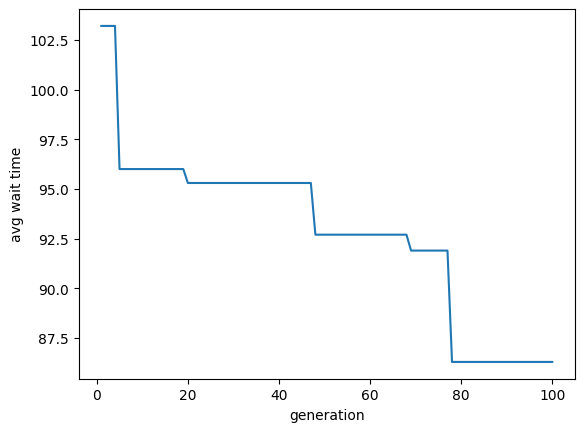

86.3

In [59]:
#SECONDS

xpoints = np.array(list(range(1, i_max+1)))
ypoints = np.array(all_fitness_winners)

plt.xlabel("generation")
plt.ylabel("avg wait time")

plt.plot(xpoints, ypoints)
plt.show()

min(all_fitness_winners)

In [60]:
min(all_fitness_winners)

86.3

one day data

In [61]:
import pandas as pd
mydata=pd.read_csv('file_name.csv')

In [62]:
subdata = mydata.loc[(mydata['year'] == 2019) & (mydata['month'] == 1)  & (mydata['day'] == 1)]
floors = array = subdata['floor'].to_numpy()
destinations = array = subdata['destination'].to_numpy()
calls = []
size = len(floors)

print ("egy napi hivas tomb merete", size)

for i in range(0, size - 1):
    calls.append([floors[i], destinations[i]])

print(calls)

egy napi hivas tomb merete 91
[[0, 8], [0, 2], [0, 17], [0, 3], [0, 11], [0, 12], [0, 10], [2, 1], [0, 9], [2, 1], [0, 19], [9, 6], [0, 19], [2, 0], [0, 6], [0, 14], [10, 8], [0, 20], [19, 14], [0, 17], [0, 8], [19, 1], [0, 15], [0, 9], [0, 9], [16, 15], [11, 0], [0, 14], [0, 14], [0, 11], [0, 10], [0, 15], [19, 10], [16, 2], [0, 7], [19, 10], [0, 9], [0, 14], [16, 8], [0, 12], [0, 1], [0, 10], [0, 18], [2, 0], [0, 17], [2, 1], [16, 12], [0, 11], [11, 4], [2, 1], [11, 1], [0, 4], [2, 1], [4, 3], [0, 16], [9, 7], [12, 10], [2, 0], [0, 18], [2, 0], [2, 1], [16, 9], [16, 10], [0, 11], [0, 8], [18, 11], [0, 16], [2, 0], [0, 14], [12, 8], [0, 16], [9, 1], [8, 4], [7, 3], [0, 8], [0, 1], [0, 5], [10, 7], [12, 7], [0, 15], [0, 11], [14, 5], [0, 8], [10, 7], [10, 4], [10, 7], [0, 9], [0, 19], [10, 5], [2, 0]]


In [64]:
calls

[[0, 8],
 [0, 2],
 [0, 17],
 [0, 3],
 [0, 11],
 [0, 12],
 [0, 10],
 [2, 1],
 [0, 9],
 [2, 1],
 [0, 19],
 [9, 6],
 [0, 19],
 [2, 0],
 [0, 6],
 [0, 14],
 [10, 8],
 [0, 20],
 [19, 14],
 [0, 17],
 [0, 8],
 [19, 1],
 [0, 15],
 [0, 9],
 [0, 9],
 [16, 15],
 [11, 0],
 [0, 14],
 [0, 14],
 [0, 11],
 [0, 10],
 [0, 15],
 [19, 10],
 [16, 2],
 [0, 7],
 [19, 10],
 [0, 9],
 [0, 14],
 [16, 8],
 [0, 12],
 [0, 1],
 [0, 10],
 [0, 18],
 [2, 0],
 [0, 17],
 [2, 1],
 [16, 12],
 [0, 11],
 [11, 4],
 [2, 1],
 [11, 1],
 [0, 4],
 [2, 1],
 [4, 3],
 [0, 16],
 [9, 7],
 [12, 10],
 [2, 0],
 [0, 18],
 [2, 0],
 [2, 1],
 [16, 9],
 [16, 10],
 [0, 11],
 [0, 8],
 [18, 11],
 [0, 16],
 [2, 0],
 [0, 14],
 [12, 8],
 [0, 16],
 [9, 1],
 [8, 4],
 [7, 3],
 [0, 8],
 [0, 1],
 [0, 5],
 [10, 7],
 [12, 7],
 [0, 15],
 [0, 11],
 [14, 5],
 [0, 8],
 [10, 7],
 [10, 4],
 [10, 7],
 [0, 9],
 [0, 19],
 [10, 5],
 [2, 0]]

In [66]:
crossover_r = 0.2
mutation_r = 0.8
maxi = 10
calls = calls_from_article
go_over_all_crossover_and_mutation_at_rates_with_data(crossover_r, mutation_r, calls, maxi)

E 1 & $ 79.94 $ & $ 76.3 $ & $ 81.9 $ & $ 4.682 $ \\
\hline
E 2 & $ 80.06 $ & $ 78.3 $ & $ 81.5 $ & $ 4.705 $ \\
\hline
E 3 & $ 80.16 $ & $ 77.1 $ & $ 83.3 $ & $ 4.702 $ \\
\hline
E 4 & $ 79.85 $ & $ 76.5 $ & $ 81.8 $ & $ 4.468 $ \\
\hline

